In [ ]:
pip install requests beautifulsoup4 robustbase


In [1]:
import requests
from bs4 import BeautifulSoup
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import numpy as np
from sklearn.preprocessing import MinMaxScaler



In [2]:
import pandas as pd
import re

# Load the CSV file
df = pd.read_csv("B:/tut-pricing-model\Makeup Essentials Scrape - Copy of Sheet1.csv", encoding="utf-8")

# Drop rows where Price is missing
df = df.dropna(subset=["Price"])

# Function to clean price values
def clean_price(price_str):
    if price_str is None:
        return None
    numeric_str = re.sub(r"[^\d\.]", "", str(price_str))
    try:
        return float(numeric_str)
    except ValueError:
        return None

# Apply price cleaning
df["price_numeric"] = df["Price"].apply(clean_price)

# Remove duplicates based on product name and cleaned price
def remove_duplicates_by_name_and_price(df):
    df = df.sort_values(by=["Product Name", "price_numeric"])
    df = df.drop_duplicates(subset=["Product Name", "price_numeric"], keep="first")
    return df

df = remove_duplicates_by_name_and_price(df)

# Filter rows where the product type is "tint" (case-insensitive match)
df_tint = df[df["Product type"].str.lower() == "tint"]

# Display the resulting filtered DataFrame
print(df_tint)


      Unnamed: 0 Website  Product type  \
2230         NaN     Noon         Tint   
2246         NaN     Noon         Tint   
2196         NaN     Noon         Tint   
2217         NaN     Noon         Tint   
2255         NaN     Noon         Tint   
...          ...      ...          ...   
981          NaN   Amazon         Tint   
979          NaN   Amazon         Tint   
978          NaN   Amazon         Tint   
2262         NaN     Noon         Tint   
2266         NaN     Noon         Tint   

                                          Product Link   \
2230  https://www.noon.com/saudi-en/color-bloom-liqu...   
2246  https://www.noon.com/saudi-en/light-pink-liqui...   
2196  https://www.noon.com/saudi-en/liquid-color-blo...   
2217  https://www.noon.com/saudi-en/liquid-color-blo...   
2255  https://www.noon.com/saudi-en/red-liquid-blush...   
...                                                 ...   
981   https://www.amazon.sa/-/en/l-f-Luminous-Shimme...   
979   https://www.amazo

<>:5: SyntaxWarning: invalid escape sequence '\M'
<>:5: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Basmala Kamal\AppData\Local\Temp\ipykernel_24556\3911248970.py:5: SyntaxWarning: invalid escape sequence '\M'
  df = pd.read_csv("B:/tut-pricing-model\Makeup Essentials Scrape - Copy of Sheet1.csv", encoding="utf-8")


In [3]:
def is_multi_item(title):
    title = title.lower()

    # Case 1: 'Set' and 'Pieces'
    if "set" in title and "pieces" in title or "bundle" in title or "pack" in title:
        return True

    # Case 2: '2-pack', 'two-pack', '2 bottles', 'two bottles'
    if re.search(r'(2-pack|two-pack|2 bottles|two bottles|two items|two)', title, re.IGNORECASE):
        return True

    # Case 3: '3 bottles', '4 pack', '5 count', etc.
    if re.search(r'\b\d+\s*(?:bottles|packs?|count)\b', title, re.IGNORECASE):
        return True

    return False

# Create a mask for sets
mask_sets = df_tint["Product Name"].apply(is_multi_item)

# Split the DataFrame
sets_df_tint = df_tint[mask_sets].copy()
df_tint = df_tint[~mask_sets].copy()

# Optional: Reset index if needed
sets_df_tint.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
print(df_tint["price_numeric"].describe())


count    274.000000
mean     110.497153
std       87.489432
min       10.950000
25%       32.122500
50%       92.250000
75%      170.000000
max      580.000000
Name: price_numeric, dtype: float64


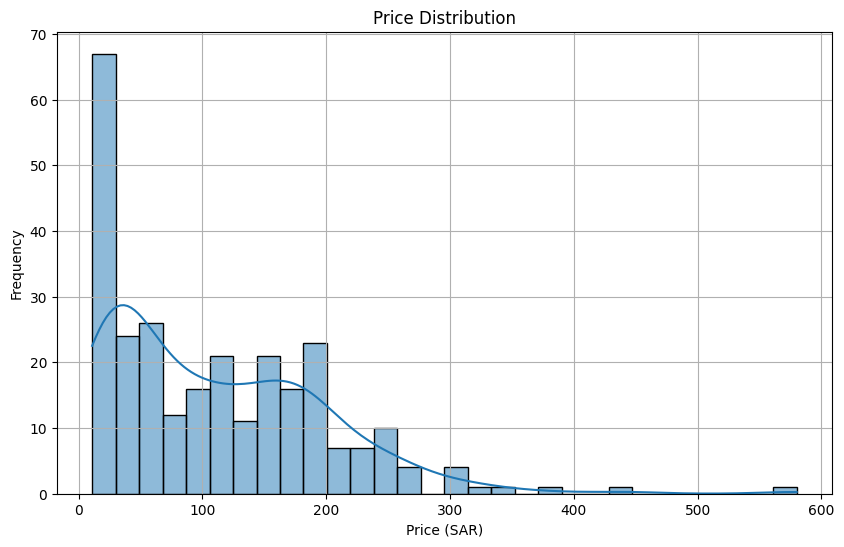

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_tint["price_numeric"].dropna(), bins=30, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (SAR)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [6]:
df_tint_cleaned = df_tint.dropna(subset=["Product Name", "price_numeric"])
df_tint_cleaned.shape

(274, 8)

In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Apply log transformation to the cleaned numeric price column
df_tint_cleaned["price_log"] = np.log1p(df_tint["price_numeric"])

# Then apply standard scaling
scaler = StandardScaler()
df_tint_cleaned["price_scaled"] = scaler.fit_transform(df_tint_cleaned[["price_log"]])


C:\Users\Basmala Kamal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Basmala Kamal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 

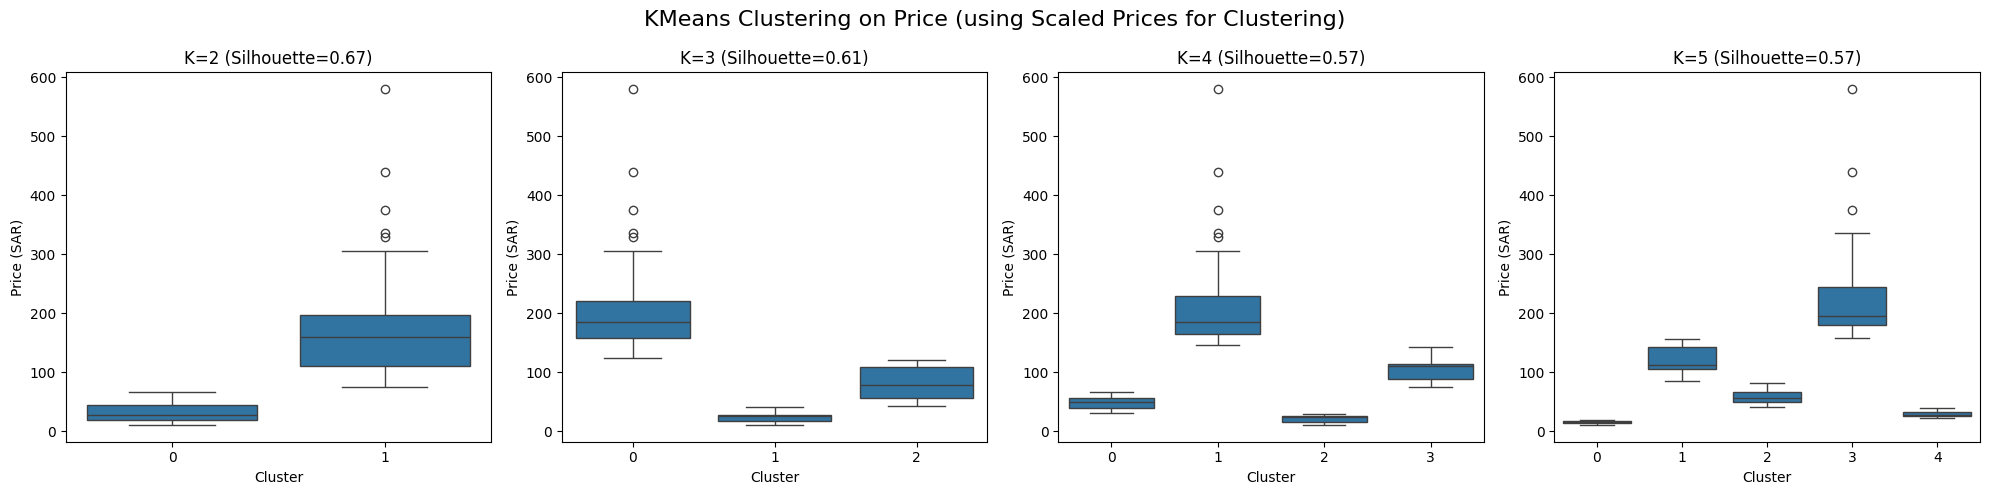

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# 2. Feature for clustering
X_price = df_tint_cleaned[["price_scaled"]].values

# 3. Plot setup
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 4. Try multiple cluster counts
for idx, k in enumerate([2, 3, 4, 5]):
    if len(df_tint_cleaned) < k:
        print(f"Skipping k={k} due to insufficient data.")
        continue

    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)

    # Add cluster labels to DataFrame
    cluster_col = f"cluster_k{k}"
    df_tint_cleaned[cluster_col] = kmeans.labels_

    # Silhouette score
    if len(set(kmeans.labels_)) > 1:
        sil_score = silhouette_score(X_price, kmeans.labels_)
    else:
        sil_score = np.nan

    # Boxplot using raw prices, grouped by cluster
    sns.boxplot(
        x=cluster_col,
        y="price_numeric",  # Show real prices
        data=df_tint_cleaned,
        ax=axes[idx]
    )
    axes[idx].set_title(f"K={k} (Silhouette={sil_score:.2f})")
    axes[idx].set_xlabel("Cluster")
    axes[idx].set_ylabel("Price (SAR)")

# Final plot formatting
plt.suptitle("KMeans Clustering on Price (using Scaled Prices for Clustering)", fontsize=16)
plt.tight_layout()
plt.show()


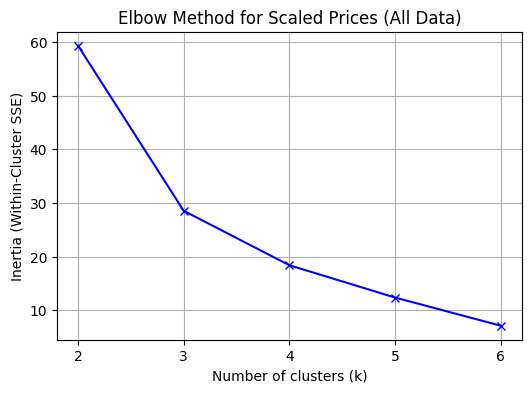

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract scaled price for clustering
X_price = df_tint_cleaned[["price_scaled"]].values

# Elbow Method: Try k from 2 to 5
distortions = []
K_range = range(2, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, 'bx-')
plt.title('Elbow Method for Scaled Prices (All Data)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.xticks(K_range)
plt.grid(True)
plt.show()


In [10]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# 1. Extract price_scaled values for clustering
X_price = df_tint_cleaned[["price_scaled"]].values

# 2. Run KMeans with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)

# 3. Assign cluster labels back to df_cleaned
df_tint_cleaned= df_tint_cleaned.copy()  # optional: avoid modifying original
df_tint_cleaned["final_cluster"] = kmeans.labels_

# 4. Show actual price statistics per cluster
summary = (
    df_tint_cleaned
    .groupby("final_cluster")["price_numeric"]
    .agg(["count", "mean", "min", "max"])
    .sort_index()
)

print("Cluster Summary Based on Actual Prices (SAR):")
print(summary)


Cluster Summary Based on Actual Prices (SAR):
               count        mean     min    max
final_cluster                                  
0                108  200.193056  125.00  580.0
1                 84   24.387976   10.95   41.0
2                 82   80.570488   42.75  121.0


In [11]:
low = df_tint_cleaned[
    (df_tint_cleaned["final_cluster"] == 1)
]
low

,Unnamed: 0,Website,Product type,Product Link,Product Img,Product Name,Price,price_numeric,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
2246,NaN,Noon,Tint,https://www.noon.com/saudi-en/light-pink-liqui...,https://f.nooncdn.com/p/pzsku/ZA24D600E0E55056...,AMYTIS GARDEN Light pink liquid blush,17.95,17.95,2.941804,-1.554002,0,1,2,0,1
2196,NaN,Noon,Tint,https://www.noon.com/saudi-en/liquid-color-blo...,https://f.nooncdn.com/p/pzsku/ZF96C45152812947...,AMYTIS GARDEN Liquid Color Bloom Blush Long-la...,17,17.00,2.890372,-1.610532,0,1,2,0,1
2217,NaN,Noon,Tint,https://www.noon.com/saudi-en/liquid-color-blo...,https://f.nooncdn.com/p/pzsku/Z33EA09198288C36...,"AMYTIS GARDEN Liquid Color Bloom Blush, Long-l...",17,17.00,2.890372,-1.610532,0,1,2,0,1
2194,NaN,Noon,Tint,https://www.noon.com/saudi-en/bogenia-angelic-...,https://f.nooncdn.com/p/pzsku/Z2618C140F704AE0...,Bogenia BOGENIA ANGELIC BLUSH Auburn BG631.004,32,32.00,3.496508,-0.944323,0,1,0,4,1
2206,NaN,Noon,Tint,https://www.noon.com/saudi-en/bogenia-match-li...,https://f.nooncdn.com/p/pzsku/Z4612FCE72EFA34B...,Bogenia Bogenia Match Liquid Blush BG636.006,33,33.00,3.526361,-0.911511,0,1,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,NaN,Amazon,Tint,https://www.amazon.sa/-/en/SHEGLAM-Define-Stic...,https://m.media-amazon.com/images/I/41TdN2uIMG...,SHEGLAM n' Define Stick - Cream Contour Stick ...,28.41,28.41,3.381335,-1.070910,0,1,2,4,1
2301,NaN,Noon,Tint,https://www.noon.com/saudi-en/cover-cream-colo...,https://f.nooncdn.com/p/pzsku/Z091F0DA4BF93D51...,SHEIDA Cover Cream Color No: 51,33.9,33.90,3.552487,-0.882796,0,1,0,4,1
2274,NaN,Noon,Tint,https://www.noon.com/saudi-en/sheloves-liquid-...,https://f.nooncdn.com/p/pzsku/Z5CEE3A25EAB2DA3...,She Loves SHELOVES Liquid Matte Blush Powder C...,19,19.00,2.995732,-1.494729,0,1,2,0,1
2863,NaN,Nahdi,Tint,https://www.nahdionline.com/en-sa/sheglam-take...,https://ecombe.nahdionline.com/media/catalog/p...,Sheglam Take A Hint Lip Tint - Level Up,26,26.00,3.295837,-1.164882,0,1,2,4,1


In [12]:
mid = df_tint_cleaned[
    (df_tint_cleaned["final_cluster"] == 2)
]
mid

,Unnamed: 0,Website,Product type,Product Link,Product Img,Product Name,Price,price_numeric,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
2230,NaN,Noon,Tint,https://www.noon.com/saudi-en/color-bloom-liqu...,https://f.nooncdn.com/p/pzsku/ZEA3DC108507ABEB...,AMYTIS GARDEN Color Bloom Liquid Blush Set (6 ...,66.65,66.65,4.214347,-0.155340,0,2,0,2,2
2255,NaN,Noon,Tint,https://www.noon.com/saudi-en/red-liquid-blush...,https://f.nooncdn.com/p/pzsku/ZB01C0AC8CBC74A1...,AMYTIS GARDEN Red liquid blush,50,50.00,3.931826,-0.465861,0,2,0,2,2
3634,NaN,Sephora,Tint,https://www.sephora.me/sa-en/p/benetint-rose-t...,https://img-product.sephora.me/dw/image/v2/BKW...,BENEFIT COSMETICS Benetint - Rose-tinted lip &...,111.00,111.00,4.718499,0.398777,1,2,3,1,2
3701,NaN,Sephora,Tint,https://www.sephora.me/sa-en/p/crystah-mini/P1...,https://img-product.sephora.me/dw/image/v2/BKW...,BENEFIT COSMETICS Crystah Mini,111.00,111.00,4.718499,0.398777,1,2,3,1,2
3693,NaN,Sephora,Tint,https://www.sephora.me/sa-en/p/dandelion-mini/...,https://img-product.sephora.me/dw/image/v2/BKW...,BENEFIT COSMETICS Dandelion Mini,111.00,111.00,4.718499,0.398777,1,2,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,NaN,Amazon,Tint,https://www.amazon.sa/-/en/l-f-Cosmetics-Lumin...,https://m.media-amazon.com/images/I/71Pab45HnK...,"e.l.f. Cosmetics Luminous Putty Blush, Putty T...",60.95,60.95,4.126328,-0.252083,0,2,0,2,2
981,NaN,Amazon,Tint,https://www.amazon.sa/-/en/l-f-Luminous-Shimme...,https://m.media-amazon.com/images/I/71WXlD+O3W...,"e.l.f. Luminous Putty Blush, Putty To Powder B...",49.45,49.45,3.920983,-0.477779,0,2,0,2,2
979,NaN,Amazon,Tint,https://www.amazon.sa/-/en/l-f-Luminous-Lightw...,https://m.media-amazon.com/images/I/71RmbOCi9N...,"e.l.f. Luminous Putty Bronzer, Lightweight Put...",60.49,60.49,4.118875,-0.260274,0,2,0,2,2
978,NaN,Amazon,Tint,https://www.amazon.sa/-/en/l-f-Pigmented-Formu...,https://m.media-amazon.com/images/I/61PNANrFr-...,"e.l.f. Putty Blush, Creamy & Ultra Pigmented F...",78.29,78.29,4.373112,0.019160,1,2,3,2,2


In [13]:
high = df_tint_cleaned[
    (df_tint_cleaned["final_cluster"] == 0)
]
high

,Unnamed: 0,Website,Product type,Product Link,Product Img,Product Name,Price,price_numeric,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
3655,NaN,Sephora,Tint,https://www.sephora.me/sa-en/p/blurring-serum-...,https://img-product.sephora.me/dw/image/v2/BKW...,ANASTASIA BEVERLY HILLS Blurring Serum Blush,140.00,140.0,4.948760,0.651859,1,0,3,1,0
3709,NaN,Sephora,Tint,https://www.sephora.me/sa-en/p/blush-trio/P307...,https://img-product.sephora.me/dw/image/v2/BKW...,ANASTASIA BEVERLY HILLS Blush Trio,206.00,206.0,5.332719,1.073871,1,0,1,3,0
3691,NaN,Sephora,Tint,https://www.sephora.me/sa-en/p/blushed-lip-%26...,https://img-product.sephora.me/dw/image/v2/BKW...,ANASTASIA BEVERLY HILLS Blushed Lip & Cheek Duo,160.00,160.0,5.081404,0.797650,1,0,1,3,0
3653,NaN,Sephora,Tint,https://www.sephora.me/sa-en/p/stick-blush/P10...,https://img-product.sephora.me/dw/image/v2/BKW...,ANASTASIA BEVERLY HILLS Stick Blush,149.00,149.0,5.010635,0.719867,1,0,1,1,0
3686,NaN,Sephora,Tint,https://www.sephora.me/sa-en/p/luminous-silk-c...,https://img-product.sephora.me/dw/image/v2/BKW...,ARMANI Luminous Silk Cheek Tint,259.00,259.0,5.560682,1.324427,1,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3710,NaN,Sephora,Tint,https://www.sephora.me/sa-en/p/eye2cheek-blush...,https://img-product.sephora.me/dw/image/v2/BKW...,VALENTINO MAKE UP Eye2Cheek Blush and Eyeshadow,336.00,336.0,5.820083,1.609537,1,0,1,3,0
3707,NaN,Sephora,Tint,https://www.sephora.me/sa-en/p/liquirosso-2-in...,https://img-product.sephora.me/dw/image/v2/BKW...,VALENTINO MAKE UP Liquirosso 2 in 1 Lip & Blus...,243.00,243.0,5.497168,1.254619,1,0,1,3,0
2312,NaN,Noon,Tint,https://www.noon.com/saudi-en/fruit-juice-liqu...,https://f.nooncdn.com/p/v1579251622/N33403706A...,VERONNI Fruit Juice Liquid Blusher 404,141,141.0,4.955827,0.659627,1,0,3,1,0
3673,NaN,Sephora,Tint,https://www.sephora.me/sa-en/p/make-me-blush-b...,https://img-product.sephora.me/dw/image/v2/BKW...,YVES SAINT LAURENT Make Me Blush - Bold Blurri...,299.00,299.0,5.703782,1.481710,1,0,1,3,0
